In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import json
import ast

In [3]:
assets = set(f.split('USD')[0] for f in os.listdir('data') if f.endswith('.csv') and 'USD' in f)

In [4]:
assets

{'BTA', 'GMMA', 'LMDA', 'ZTA'}

Collect and visualize data

In [5]:
trades = {}
mkt_data_raw = {}
trades_data_raw = {}

for asset in assets:

    with open(f'data/{asset}USD.json') as f:
        d = json.load(f)
        tick_size = d['tick_size'] 



    df_mkt = pd.read_csv(f'data/{asset}USD_md.csv', index_col=0)
    df_mkt.index = pd.to_datetime(df_mkt.index, unit = 'ms')

    for col in df_mkt.columns:
        df_mkt[col] = np.round(df_mkt[col] / tick_size) * tick_size


    df_mkt['mid'] = .5 * (df_mkt.ask + df_mkt.bid) 
    df_mkt['spread'] = df_mkt.ask - df_mkt.bid

    mkt_data_raw[asset] = df_mkt
    
    df_trades = pd.read_csv(f'data/{asset}USD_trades.csv', index_col=0)
    df_trades.index = pd.to_datetime(df_trades.index, unit = 'ms')
    df_trades.sort_index(inplace=True)
    df_trades.px = np.round(df_trades.px / tick_size) * tick_size
    trades_data_raw[asset] = df_trades

    df_trades_vs_mkt = pd.merge_asof(left = df_mkt,
                                     right= df_trades[['trade_id', 'side', 'size', 'px']],
                                     left_index = True,
                                     right_index=True,
                                     direction = 'backward'
                                     )
    
    trades[asset] = df_trades_vs_mkt

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_908/2528756274.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


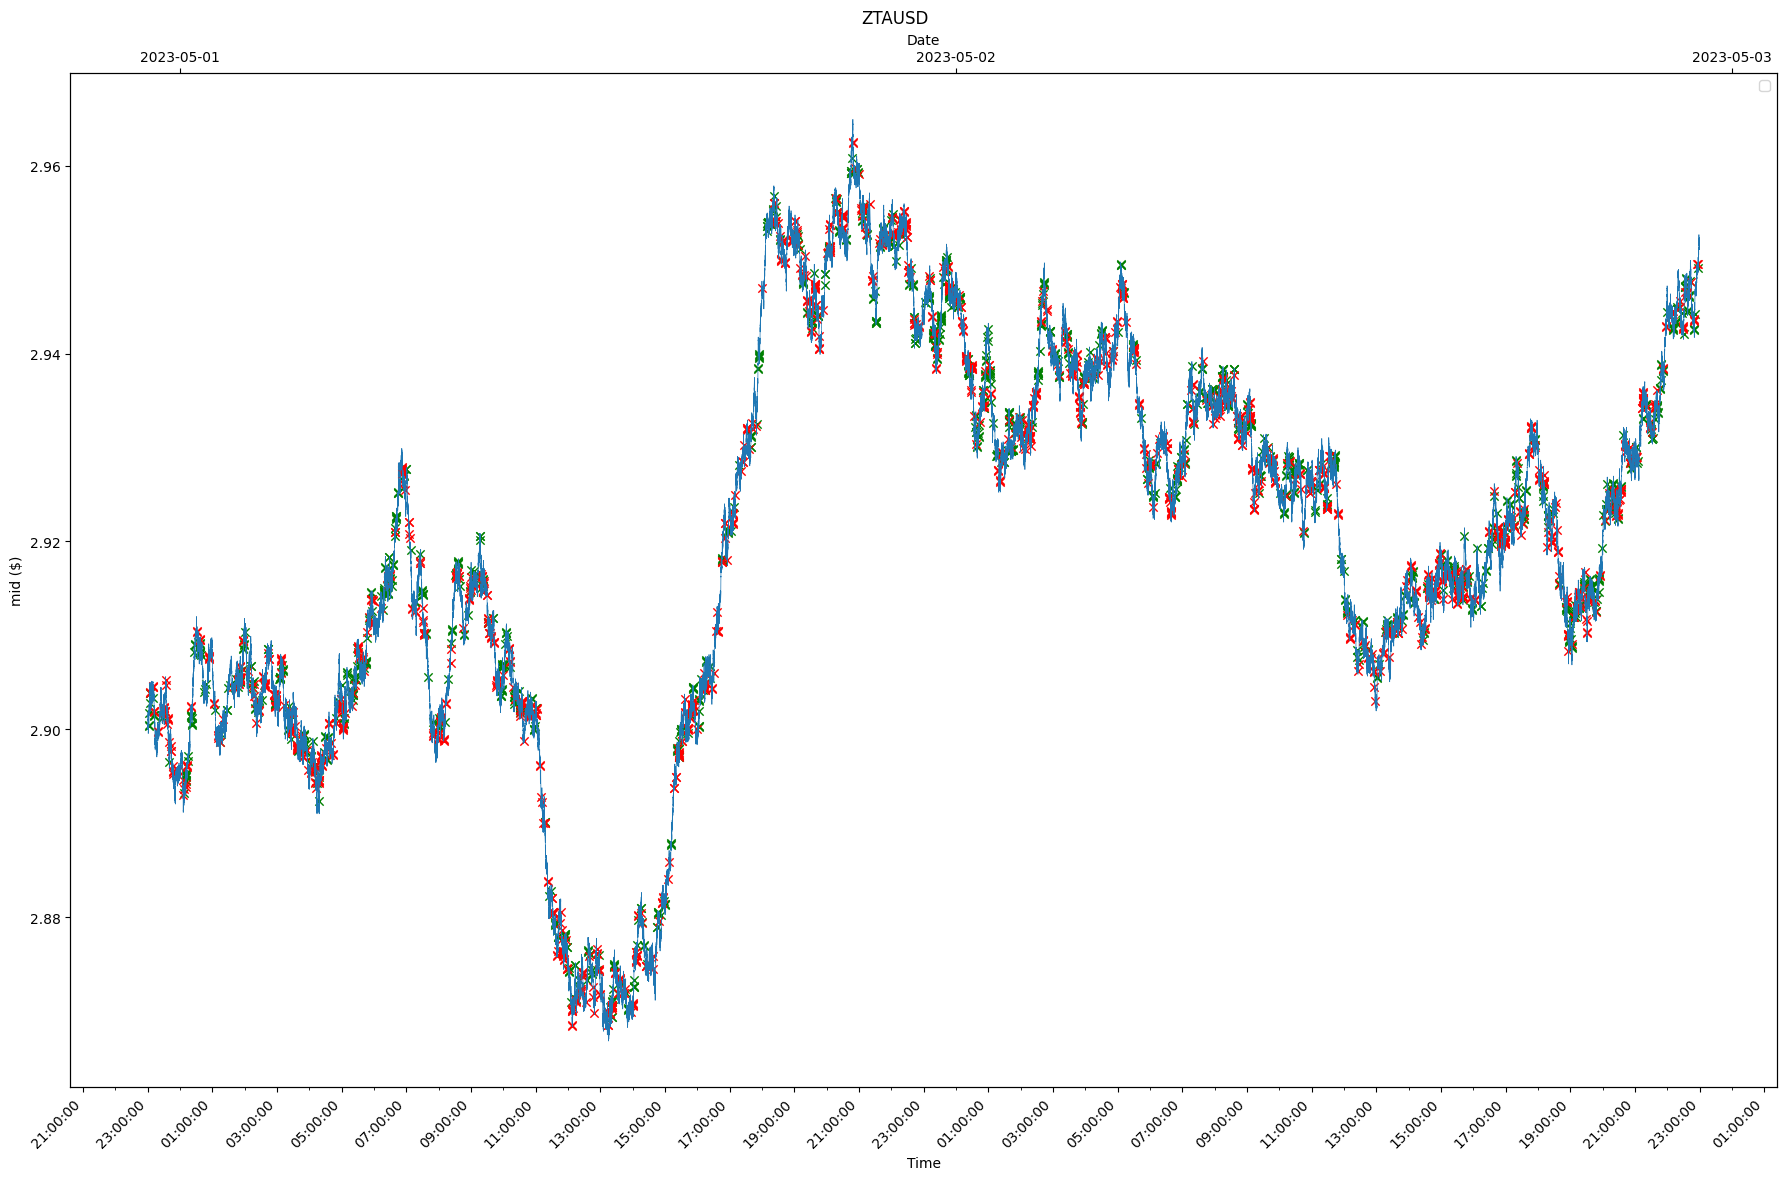

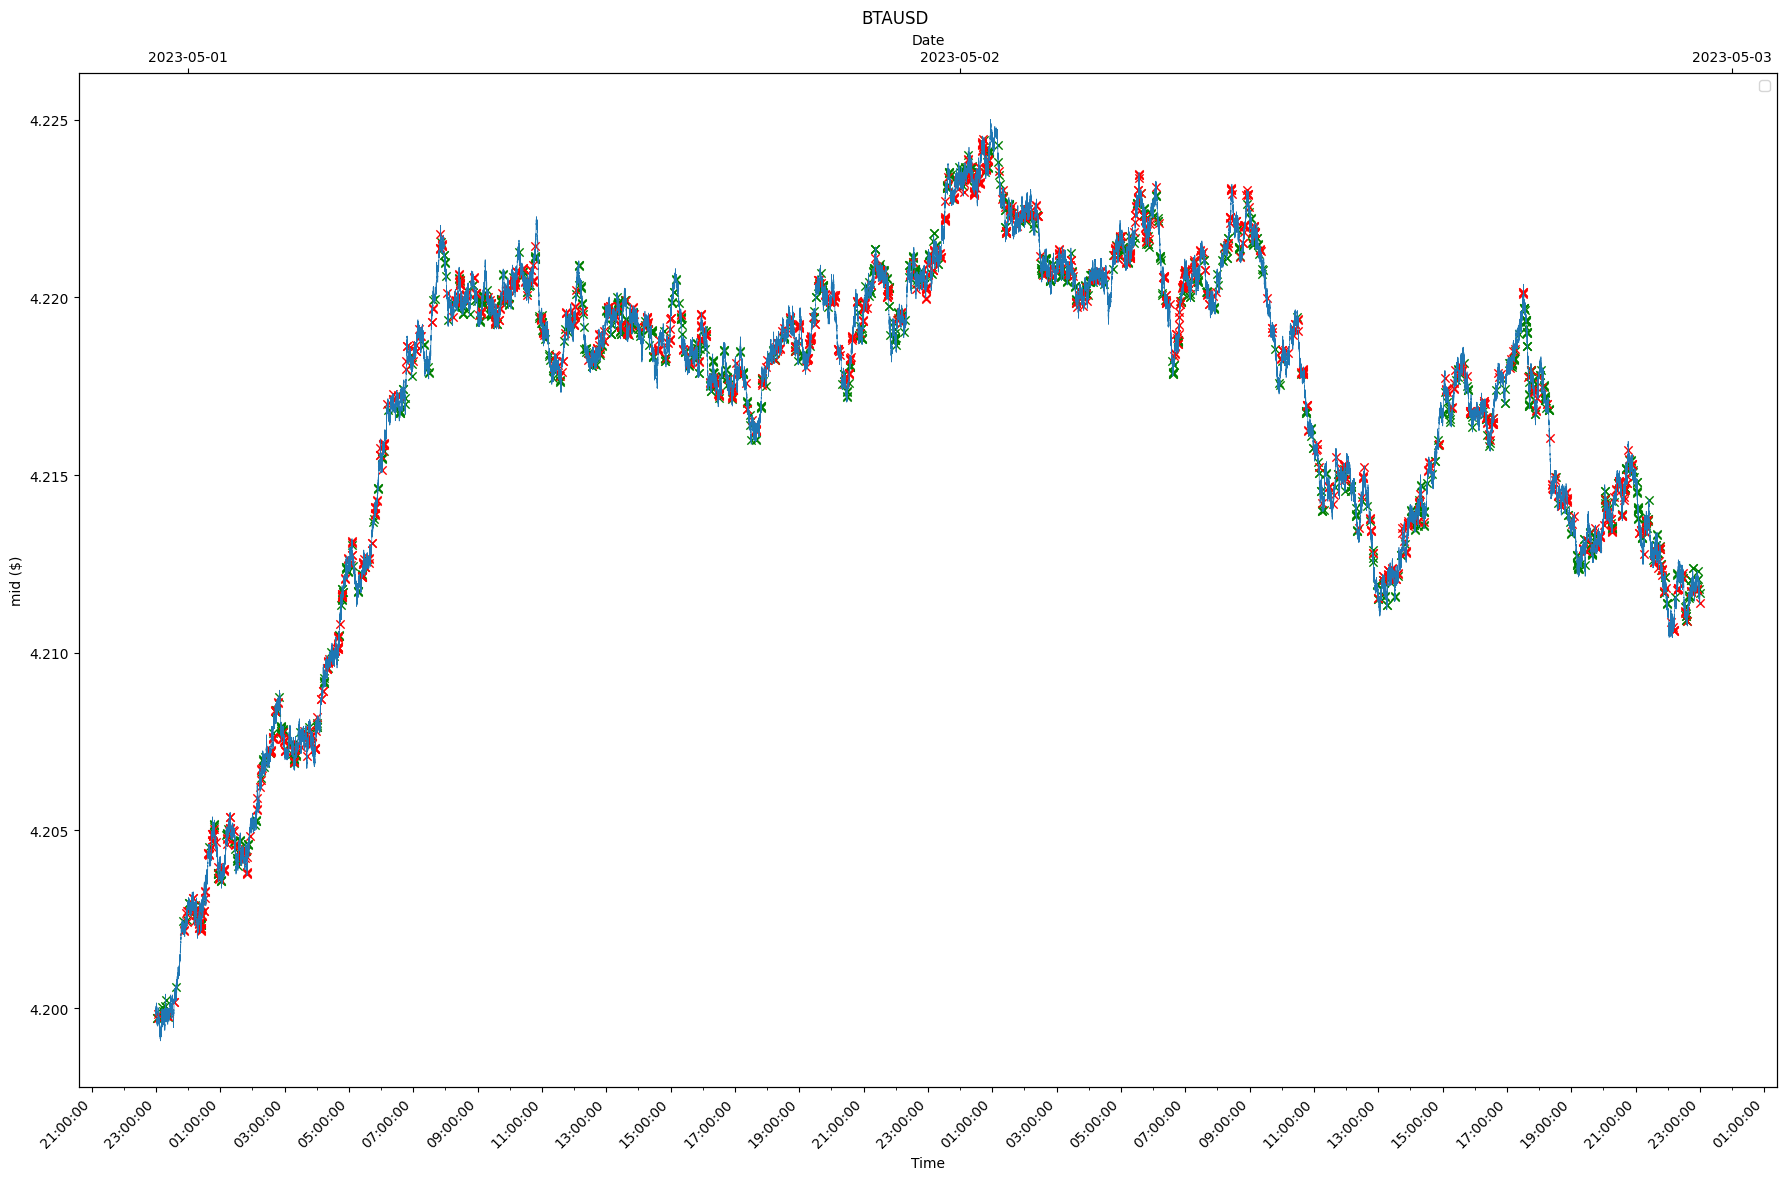

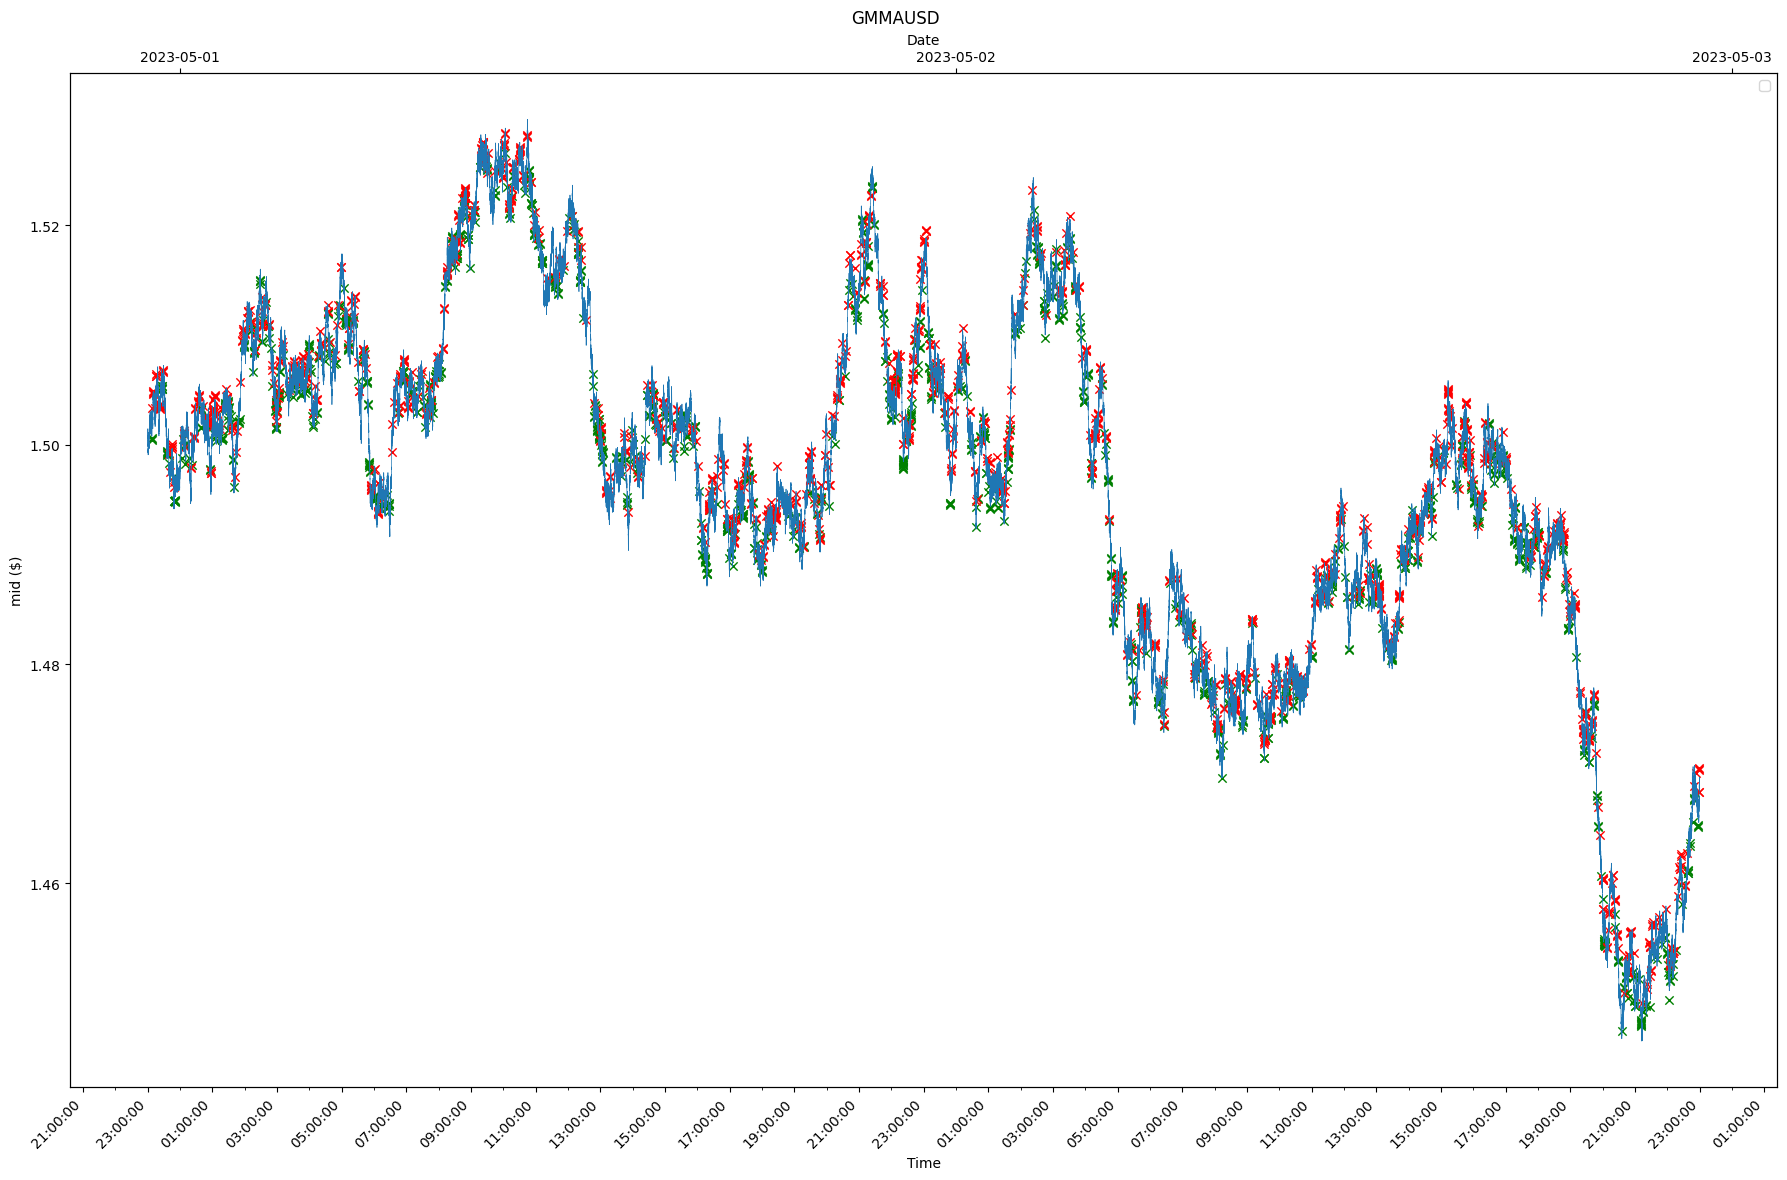

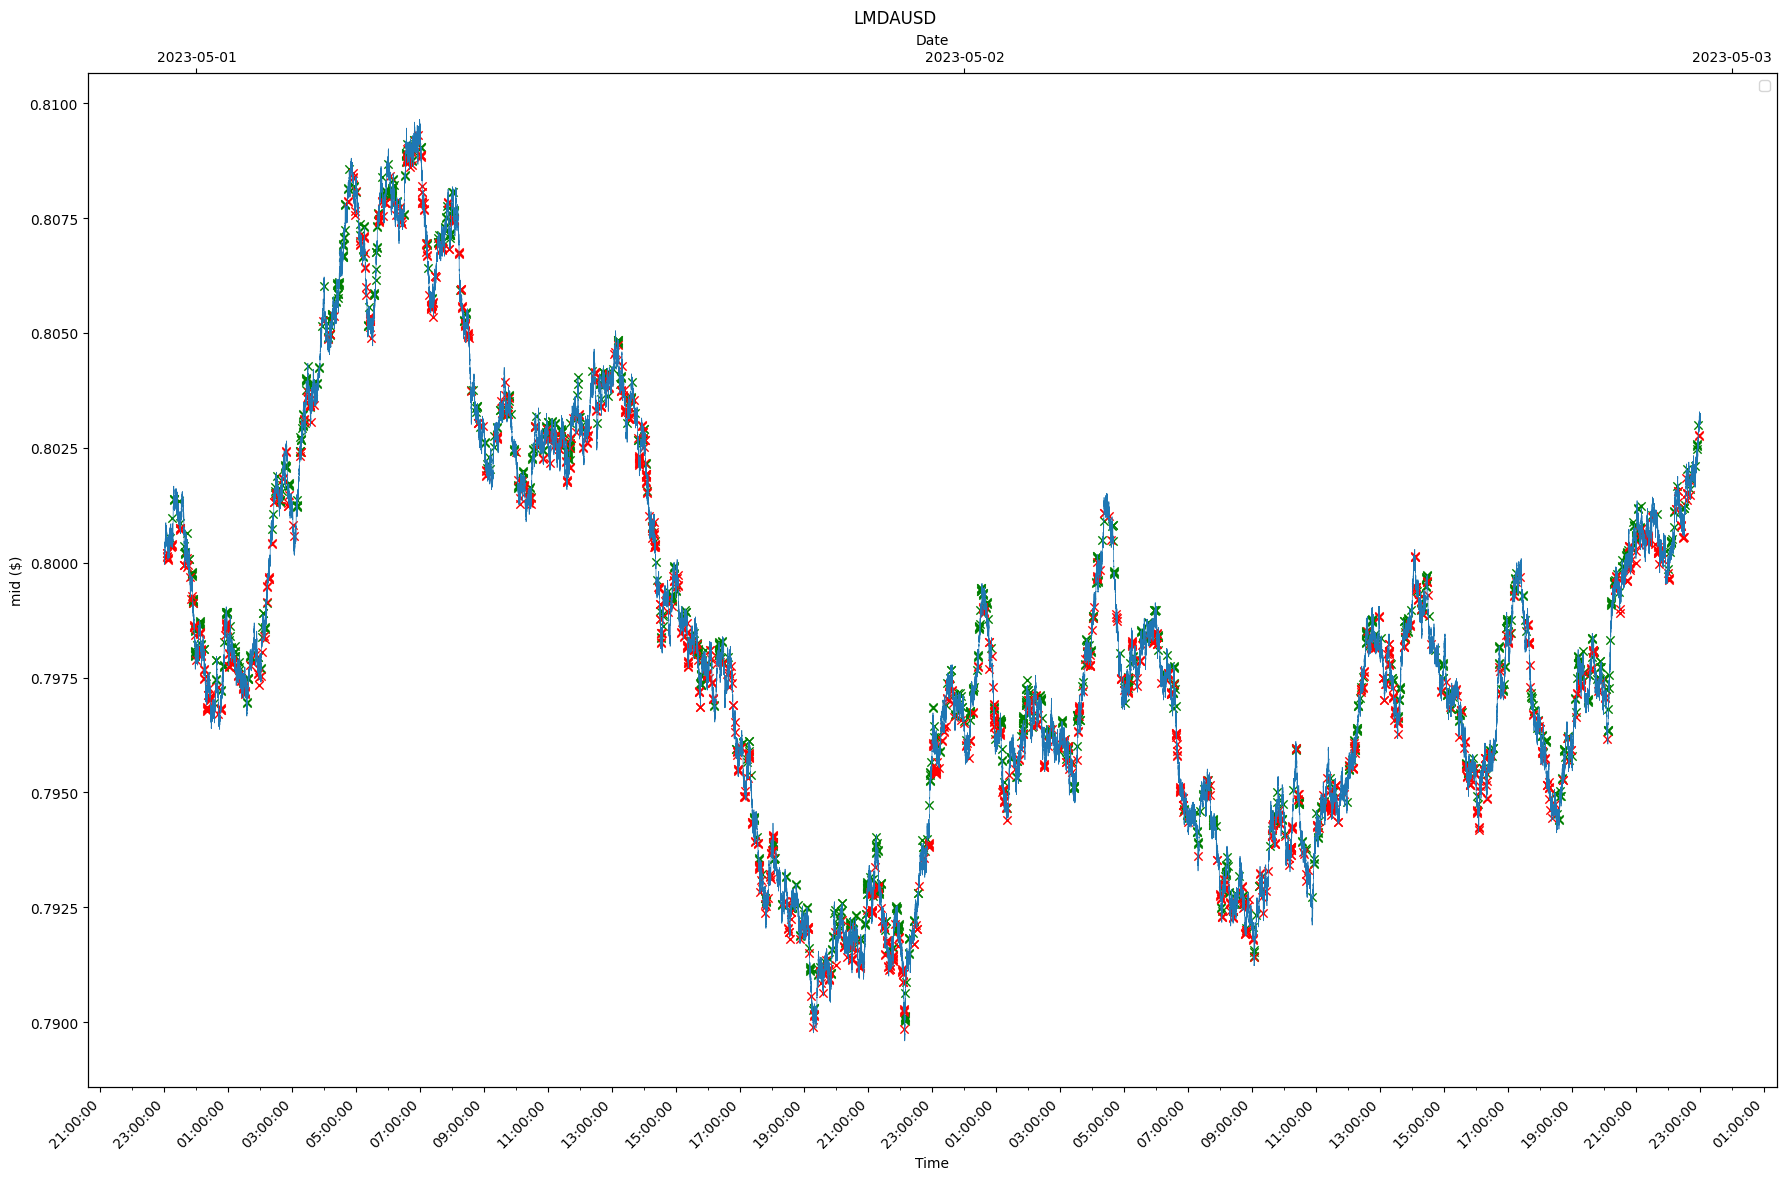

In [6]:
for asset, df in trades.items():
    fig, axs = plt.subplots(figsize=(18, 12))
    fig.suptitle(f'{asset}USD')
    
    axs.plot(df.index, df.mid, linewidth=.5)

    buys = df[df.side == 'B'].drop_duplicates('trade_id')
    sells = df[df.side == 'S'].drop_duplicates('trade_id')

    axs.scatter(buys.index, buys.px, color='green', marker='x',
                label='buy', linewidth=1)
    
    axs.scatter(sells.index, sells.px, color='red', marker='x',
                label='sell', linewidth=1)

    axs.set_ylabel('mid ($)')
    
    # Configure bottom x-axis (primary) to show time
    axs.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Every 2 hours
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour
    axs.set_xlabel('Time')
    
    # Add top x-axis for date only
    ax2 = axs.twiny()
    ax2.set_xlim(axs.get_xlim())  # Match the primary axis range
    ax2.xaxis.set_major_locator(mdates.DayLocator())  # Every day
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.set_xlabel('Date')
    
    # Rotate the time labels at the bottom for better readability
    plt.setp(axs.get_xticklabels(), rotation=45, ha='right')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

Per asset analysis

In [68]:
def hourly_plot(df: pd.DataFrame, start: str, end: str, asset: str):

    df_zoom = df[(df.index > start ) & (df.index < end )]

    fig, axs = plt.subplots(figsize=(15, 10))
    fig.suptitle(f'{asset}USD')

    #axs.plot(df_zoom.index, df_zoom.mid, linewidth=.5)
    axs.plot(df_zoom.index, df_zoom.bid, linewidth=.25, label = 'bid', color = 'tan')
    axs.plot(df_zoom.index, df_zoom.ask, linewidth=.25, label = 'ask', color = 'grey')

    buys = df_zoom[df_zoom.side == 'B'].drop_duplicates('trade_id')
    sells = df_zoom[df_zoom.side == 'S'].drop_duplicates('trade_id')

    axs.scatter(buys.index, buys.px, color='green', marker='x',
                label='buy', linewidth=2)

    axs.scatter(sells.index, sells.px, color='red', marker='x',
                label='sell', linewidth=2)

    axs.set_ylabel('mid ($)')
 
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator(byminute=[0, 15, 30, 45]) 
    hours_fmt = mdates.DateFormatter('%H:%M:%S')

    date_str = df_zoom.index[0].strftime('%Y-%m-%d')
    plt.xlabel(f'Time (Date: {date_str})')

    axs.xaxis.set_major_locator(hours)
    axs.xaxis.set_major_formatter(hours_fmt)
    axs.xaxis.set_minor_locator(minutes)

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [69]:
with open('data/horizon_ticks', 'r') as f:
    ticks_str = f.read()
    ticks = ast.literal_eval(ticks_str)

In [ ]:
def synch_horizons_and_market_prices(df_mkt, df_trades, horizons):
    
    market_data = df_mkt.copy()
    trades = df_trades.copy()
    
    
    trades = trades.reset_index().rename(columns={'ts_ms': 'trade_time'})
    market_data = market_data.reset_index().rename(columns={'ts_ms': 'timestamp'})
    
    
    horizon_dfs = []
    
    for horizon in horizons:
        horizon_df = trades.copy()
        
        horizon_df['target_time'] = horizon_df['trade_time'] + pd.Timedelta(milliseconds=horizon)
        
        horizon_df['horizon'] = horizon
        
        horizon_dfs.append(horizon_df)
    
    
    all_horizons = pd.concat(horizon_dfs, ignore_index=True)
    
    
    all_horizons = all_horizons.sort_values('target_time')
    market_data = market_data.sort_values('timestamp')
    
    
    merged = pd.merge_asof(
        all_horizons,
        market_data,
        left_on='target_time',
        right_on='timestamp',   
        direction='forward'  # Get most recent price before target time
    )

    return merged

def markouts(trades: pd.DataFrame) -> pd.DataFrame:
    
    buy_mask = trades['side'] == 'B'
    sell_mask = trades['side'] == 'S'

    trades['raw_pnl'] = np.nan
    
    trades.loc[buy_mask, 'raw_pnl'] = trades.loc[buy_mask, 'bid'] - trades.loc[buy_mask, 'px']
    trades.loc[sell_mask, 'raw_pnl'] = trades.loc[sell_mask, 'px'] - trades.loc[sell_mask, 'ask']
    
    trades['margin'] = trades['raw_pnl'] / trades['size']  
    
    result_df = trades[['trade_id', 'horizon', 'margin']].copy()
    
    return result_df

def aggregate_margins(markouts: pd.DataFrame) -> pd.DataFrame:

    aggregates = markouts.groupby('horizon')[['margin']].mean()
    return aggregates

def get_trades_margin(mkt_data, trades_data):
    
    synched = synch_horizons_and_market_prices(mkt_data, trades_data)
    trades_markouts = markouts(synched)
    margins = aggregate_margins(trades_markouts)

    return margins

BTA

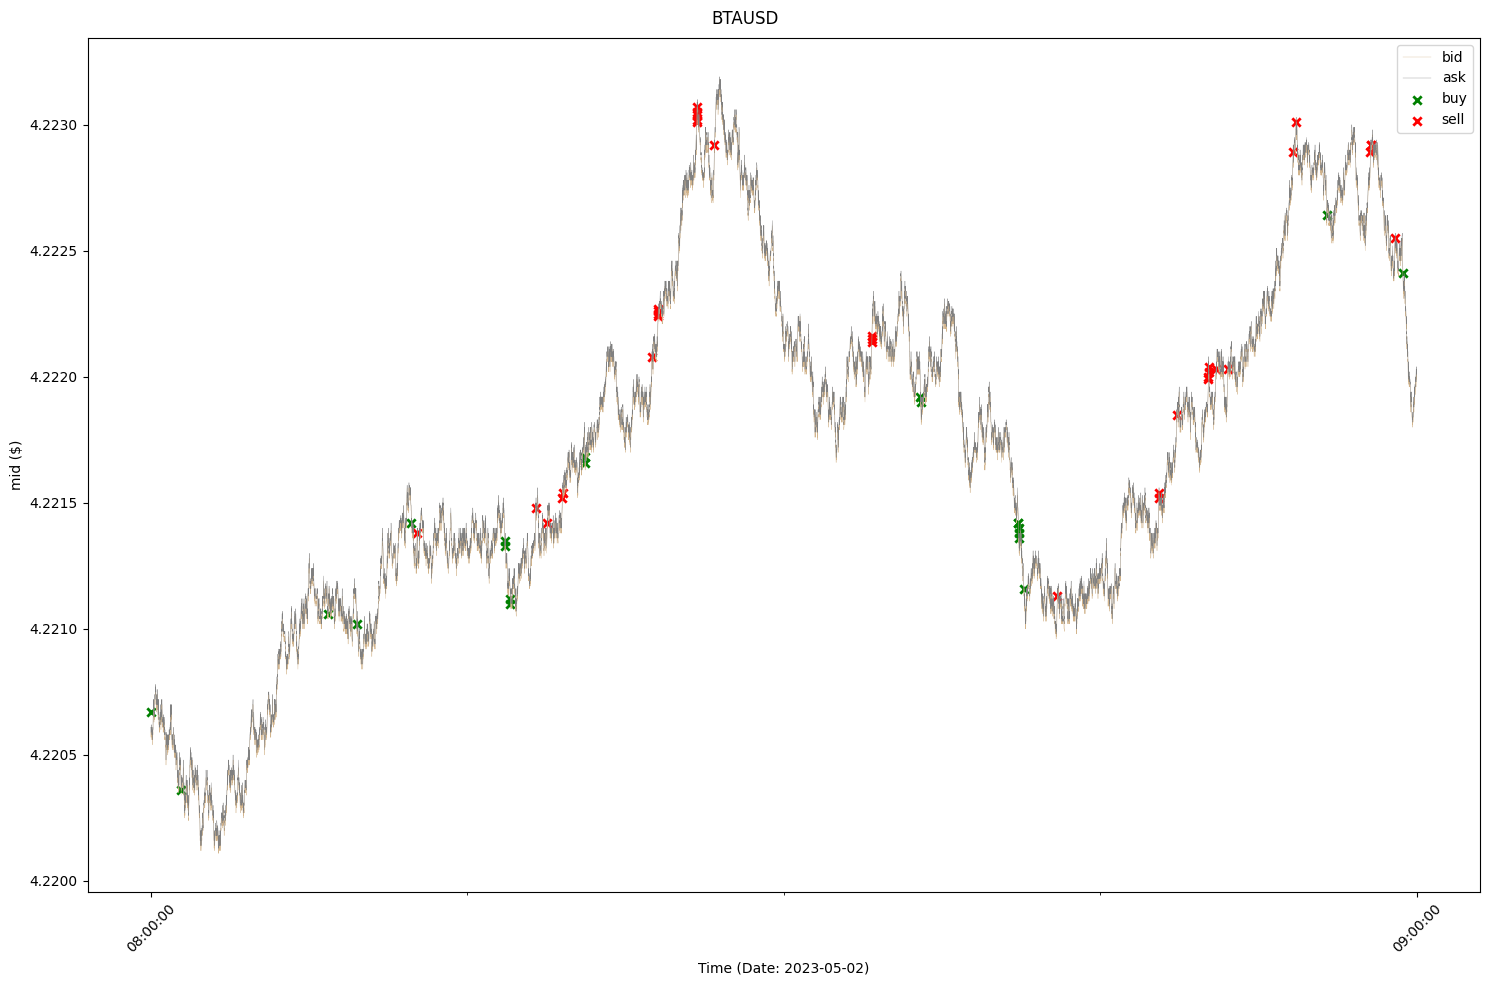

In [74]:
asset = 'BTA'
df = trades[asset]

hourly_plot(df, '2023-05-02 8:00', '2023-05-02 9:00', asset)

In [ ]:
def synch_horizons_and_market_prices(df_mkt, df_trades, horizons):
    # Make a copy to avoid modifying the original
    market_data = df_mkt.copy()
    trades = df_trades.copy()
    
    # Reset indices to use timestamps as columns
    trades = trades.reset_index().rename(columns={'ts_ms': 'trade_time'})
    market_data = market_data.reset_index().rename(columns={'ts_ms': 'timestamp'})
    
    # Pre-compute all target timestamps for each trade and horizon
    horizon_dfs = []
    
    for horizon in horizons:
        horizon_df = trades.copy()
        
        horizon_df['target_time'] = horizon_df['trade_time'] + pd.Timedelta(milliseconds=horizon)
        
        horizon_df['horizon'] = horizon
        
        horizon_dfs.append(horizon_df)
    
    # Combine all horizon dataframes
    all_horizons = pd.concat(horizon_dfs, ignore_index=True)
    
    # Sort dataframes for merge_asof
    all_horizons = all_horizons.sort_values('target_time')
    market_data = market_data.sort_values('timestamp')
    
    # Find the market price at each target time using merge_asof
    merged = pd.merge_asof(
        all_horizons,
        market_data,
        left_on='target_time',
        right_on='timestamp',   
        direction='forward'  # Get most recent price before target time
    )

    return merged

def markouts(trades: pd.DataFrame) -> pd.DataFrame:
    
    buy_mask = trades['side'] == 'B'
    sell_mask = trades['side'] == 'S'

    trades['raw_pnl'] = np.nan
    
    trades.loc[buy_mask, 'raw_pnl'] = trades.loc[buy_mask, 'bid'] - trades.loc[buy_mask, 'px']
    trades.loc[sell_mask, 'raw_pnl'] = trades.loc[sell_mask, 'px'] - trades.loc[sell_mask, 'ask']
    
    trades['margin'] = trades['raw_pnl'] / trades['size']  # normalize by volume
    
    # Reshape to have trades as rows and horizons as columns
    result_df = trades[['trade_id', 'horizon', 'margin']].copy()
    
    return result_df

def aggregate_margins(markouts: pd.DataFrame) -> pd.DataFrame:

    aggregates = markouts.groupby('horizon')[['margin']].mean()
    return aggregates

def get_trades_margin(mkt_data, trades_data):
    
    synched = synch_horizons_and_market_prices(mkt_data, trades_data)
    trades_markouts = markouts(synched)
    margins = aggregate_margins(trades_markouts)

    return margins

In [ ]:
synched = synch_horizons_and_market_prices(mkt_data_raw[asset], trades_data_raw[asset], ticks)


In [105]:
synched.head()

,trade_time,trade_id,side,size,px,lhs_ccy,rhs_ccy,target_time,horizon,timestamp,bid,ask,mid,spread
0,2023-04-30 23:02:12.275,0,B,3000.0,4.19972,BTA,USD,2023-04-30 23:02:02.275,-10000,2023-04-30 23:02:02.300,4.19948,4.19986,4.19967,0.00038
1,2023-04-30 23:02:12.350,1,B,2000.0,4.19972,BTA,USD,2023-04-30 23:02:02.350,-10000,2023-04-30 23:02:02.400,4.19948,4.19986,4.19967,0.00038
2,2023-04-30 23:02:12.275,0,B,3000.0,4.19972,BTA,USD,2023-04-30 23:02:02.375,-9900,2023-04-30 23:02:02.400,4.19948,4.19986,4.19967,0.00038
3,2023-04-30 23:02:12.350,1,B,2000.0,4.19972,BTA,USD,2023-04-30 23:02:02.450,-9900,2023-04-30 23:02:02.500,4.19948,4.19986,4.19967,0.00038
4,2023-04-30 23:02:12.275,0,B,3000.0,4.19972,BTA,USD,2023-04-30 23:02:02.475,-9800,2023-04-30 23:02:02.500,4.19948,4.19986,4.19967,0.00038


In [106]:
trades_markouts = markouts(synched)

In [107]:
trades_markouts.head()

,trade_id,horizon,margin
0,0,-10000,-8.000000e-08
1,1,-10000,-1.200000e-07
2,0,-9900,-8.000000e-08
3,1,-9900,-1.200000e-07
4,0,-9800,-8.000000e-08


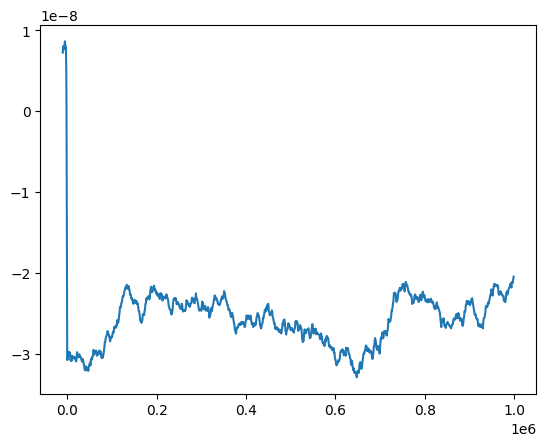

In [108]:
df = aggregate(trades_markouts)
plt.plot(df.margin)